# Compare Cloud-Optimized Geotiffs from ASDI "sentinel-s1-rtc-indigo" S3 buckets 

This notebook shows an option on how to construct a multidimensional xarray DataArray from multiple 2D Images COGS

# Sentinel-1 Radiometric Terrain Corrected (RTC) Data

https://sentinel-s1-rtc-indigo-docs.s3-us-west-2.amazonaws.com/index.html

The Sentinel-1 mission is a constellation of two C-band Synthetic Aperature Radar (SAR) imaging satellites from the European Space Agency (ESA). These satellites were launched in 2014 (S1A) and 2016 (S1B) and are capable of providing imagery in all-weather, day or night, under a few different observation configurations. Each satellite has a repeat cycle of 12-days and completes 175 orbits per cycle, giving it a potential 6-day repeat coverage time.

 he Sentinel-1 data included in this dataset are from the “Interferometric Wide Swath” (IW) mode, which is the main acquisition mode over land. The data were first preprocesed by ESA into a Level-1 “Ground Range Detected” (GRD) product, which involves detection, multi-looking, and projection to ground-range using a simple Earth ellipsoid model.

We have applied additional processing steps on top of the “GRD” product to make it “Radiometric Terrain Corrected” (RTC), including calibration, noise removal, speckle filtering, and radiometric and terrain correction. We also transform the dataset from a collection of “scenes”, or slices of orbital passes, into a regularly gridded, “tiled” data product. We perform these steps to make the imagery suitable for analysis, but some preprocessing choices may not fit your application. For more information, see the Methodology section.

This product is available for the Contiguous United States (CONUS) only, which has been mapped routinely over the enter domain since 2017 in dual-vertical (DV) polarization mode on ascending orbits. We update the dataset with newly acquired Sentinel-1 data on a daily cadence.

In [50]:
# please use the environement.ymal file to create the needed environement with conda
#%pip install rioxarray intake intake-xarray rasterio datashader s3fs hvplot

In [148]:
import matplotlib
import hvplot
import dask
import s3fs
import intake
import os
import rasterio
import rioxarray
import xarray as xr
import pandas as pd

In [149]:
# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='2000000000',
           GDAL_SWATH_SIZE='2000000000',
           VSI_CURL_CACHE_SIZE='2000000000')
os.environ.update(env)

#define year in scope
year = '2017'

https://sentinel-s1-rtc-indigo-docs.s3-us-west-2.amazonaws.com/data_format.html

In [156]:
# set up a connection with credentials and other settings
s3 = s3fs.S3FileSystem(anon=True)
objects = s3.ls('sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/' + year + '/')
images = ['s3://' + obj + '/Gamma0_VV.tif' for obj in objects]
print(len(images))
images[:6] 

#aws s3 ls --no-sign-request s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/T/ET/
#s3://sentinel-s1-rtc-indigo/tiles/RTC/1/[MODE]=IW/[MGRS UTM zone]/[MGRS latitude label]/[MGRS Grid Square ID]/[YEAR]/[SATELLITE]_[DATE]_[TILE ID]_[ORBIT DIRECTION]/[ASSET]

83


['s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170102_19TDK_ASC/Gamma0_VV.tif',
 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170109_19TDK_ASC/Gamma0_VV.tif',
 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170114_19TDK_ASC/Gamma0_VV.tif',
 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170121_19TDK_ASC/Gamma0_VV.tif',
 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170126_19TDK_ASC/Gamma0_VV.tif',
 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/2017/S1A_20170202_19TDK_ASC/Gamma0_VV.tif']

A GDAL VRT file is an XML format that can group together many separate files into separate bands. 
It's common to create such a file with a the GDAL command line tool `gdalbuildvrt`, illustrated below:

In [157]:
#step 1) write a file list that points to the data. GDAL requires special prefixes for this /vsis3/ or /vsicurl/
with open('files_runtime_inventory.txt', 'w') as f:
    lines = [x.replace('s3://', '/vsis3/') + '\n' for x in images[:6]]
    f.writelines(lines)
#print(lines)

In [158]:
%%time
# step 2) create a VRT file
!gdalbuildvrt stack.vrt -separate -input_file_list files_runtime_inventory.txt 

0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 47.6 ms, sys: 21.9 ms, total: 69.5 ms
Wall time: 3.34 s


In [159]:
%%time
# step 3) open with xarray
chunks=dict(band=1, x=2745, y=2745)
#da = xr.open_rasterio('stack.vrt', chunks=chunks)
ds = xr.open_dataset('stack.vrt', chunks=chunks, engine="rasterio")
ds

CPU times: user 4.39 ms, sys: 12.3 ms, total: 16.7 ms
Wall time: 18.1 ms


<xarray.Dataset>
Dimensions:      (band: 2, x: 5490, y: 5490)
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 2745, 2745), meta=np.ndarray>

In [161]:
# step 4) optionally modify coordinates (e.g. time dimension extracted from file name)
#ds = ds.rename({'band':'time'})
ds['time'] = [pd.to_datetime(x[60:68]) for x in images[:]]

1. `xr.open_rasterio(stack.vrt)` stores band coordinates as sequential integers (we lose file name and metadata from each individual COG, so it's common to alter the coordinates after opening the dataset)
2. data is tied to a reference to a local file ('stack.vrt'), which can cause problems with distributed computing if you don't have access to the local filesystem

## intake-xarray

[intake-xarray](https://github.com/intake/intake-xarray) is a plugin for the intake library. It uses fsspec/s3fs under the hood to facilitate loading data into python objects. the function `intake.open_rasterio()` accepts a list of paths. it returns an intake object with a `to_dask()` function that returns an xarray DataArray

In [162]:
%%time
# ~ 1s for 6 files

# this loads the image ID into xarray's band coordinates. 

pattern = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/19/T/DK/' + year + '/{band}/Gamma0_VV.tif'
chunks=dict(band=1, x=5490, y=5490)
sources = intake.open_rasterio(images[:], chunks=chunks, path_as_pattern=pattern, concat_dim='band')
ds = sources.to_dask() 
ds

CPU times: user 75.6 ms, sys: 12.7 ms, total: 88.3 ms
Wall time: 93.6 ms


<xarray.DataArray (band: 83, y: 5490, x: 5490)>
dask.array<concatenate, shape=(83, 5490, 5490), dtype=float32, chunksize=(1, 5490, 5490), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U22 'S1A_20170102_19TDK_ASC' ... 'S1B_20171123_19TDK_ASC'
  * y        (y) float64 5e+06 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
Attributes:
    transform:              (20.0, 0.0, 399960.0, 0.0, -20.0, 5000040.0)
    crs:                    +init=epsg:32619
    res:                    (20.0, 20.0)
    is_tiled:               1
    nodatavals:             (0.0,)
    scales:                 (1.0,)
    offsets:                (0.0,)
    descriptions:           ('Gamma0_VV',)
    ABSOLUTE_ORBIT_NUMBER:  14659
    AREA_OR_POINT:          Area
    DATE:                   2017-01-02
    MISSION_ID:             S1A
    NUMBER_SCENES:          2
    ORBIT_DIRECTION:        ascending
    OVR_RESAMPLING_ALG:     AVERAGE
    SCENES:                 S1A_IW_GRDH_1SDV_20170102T223504_20170102T223529_...
    SCENE_1_METADATA:       {"title": "S1A_IW_GRDH_1SDV_20170102T223504_20170...
    SCENE_1_PRODUCT_INFO:   {"id": "S1A_IW_GRDH_1SDV_20170102T223504_20170102...
    SCENE_2_METADATA:       {"title": "S1A_IW_GRDH_1SDV_20170102T223529_20170...
    SCENE_2_PRODUCT_INFO:   {"id": "S1A_IW_GRDH_1SDV_20170102T223529_20170102...
    TILE_ID:                19TDK
    VALID_PIXEL_PERCENT:    96.608

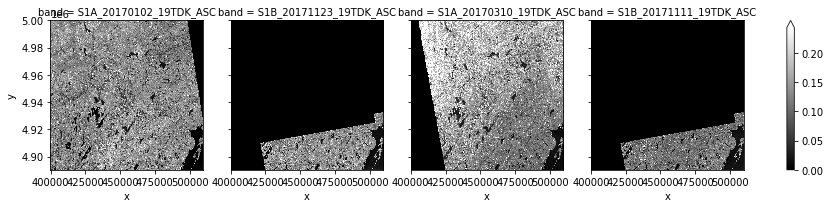

In [163]:
rgb_bands = ['S1A_20170102_19TDK_ASC', 'S1B_20171123_19TDK_ASC', 'S1A_20170310_19TDK_ASC', 'S1B_20171111_19TDK_ASC']
ds.sel(band=rgb_bands).plot.imshow(col='band', robust=True, cmap='gray', clim=(0,0.4))

In [59]:
import hvplot.xarray
ds.hvplot.image(rasterize=True, aspect='equal', cmap='gray', clim=(0,0.4), frame_width=600, frame_height=600, widget_type='scrubber', widget_location='bottom')

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=82, width=550)
        [2] HSpacer()

## Custom

You can also just use xarray and dask to construct a larger datacube from many COGS. 

In [60]:
%%time

# 4 - 8 s
# Load all the images

chunks=dict(band=1, x=2745, y=2745)
dataArrays = [xr.open_dataset(url, chunks=chunks, engine="rasterio") for url in images]

# note use of join='override' b/c we know these COGS have the same coordinates
ds = xr.concat(dataArrays, dim='band', join='override', combine_attrs='drop')
ds = ds.rename({'band':'time'})
ds['time'] = [pd.to_datetime(x[60:68]) for x in images]
ds

CPU times: user 751 ms, sys: 106 ms, total: 857 ms
Wall time: 30.8 s


<xarray.Dataset>
Dimensions:      (time: 83, x: 5490, y: 5490)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02 2017-01-09 ... 2017-11-23
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
  * y            (y) float64 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06 4.89e+06
    spatial_ref  int64 0
Data variables:
    band_data    (time, y, x) float32 dask.array<chunksize=(1, 2745, 2745), meta=np.ndarray>

#### recap:

* The cell above is essentially a for-loop that iterates over each COG in sequence. 50ms-200ms * 80 ~ 4-16 seconds. The next notebook will look at using Dask to speed things up by opening the files in parallel.

## Visualize

Here is an example of interactive visualization again using hvplot. Since we're using full resolution arrays it's key to set the `rasterize=True` keyword argument. That uses the datashader library to pre-render images before sending them to the browser.

This is extremely powerful because, resolution updates as you zoom in, and you can scrub through the data cube with an interactive slider widget

In [61]:
import hvplot.xarray
ds.hvplot.image(rasterize=True, aspect='equal', cmap='gray', clim=(0,0.4))

:DynamicMap   [time]
   :Image   [y,x]   (band_data)